In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import netCDF4 as nc
import datetime as dt
import cmocean
import string
import glob
import pickle
import matplotlib as mpl
from salishsea_tools import evaltools as et
from salishsea_tools import bio_tools as bt
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)
mpl.rc('legend', fontsize=8)
mpl.rc('axes', titlesize=8)
mpl.rc('axes', labelsize=8)
mpl.rc('figure', titlesize=8)
mpl.rc('font', size=8)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 ''')
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
from scipy.ndimage import gaussian_filter
from matplotlib.ticker import FormatStrFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
#from NorthNut import vvl_interp_T_to_V, vvl_interp_T_to_U;

%matplotlib inline

fluxes due to constant sinking rates (PON and bSi) can be calculated from daily mean concentrations

In [2]:
SOGtmaskPath='../../save/SOGtmask.pkl'
(tmaskSOG,ig0,ig1,jg0,jg1)=pickle.load(open(SOGtmaskPath,'rb'))

In [3]:
tmaskSOG.shape,ig0

((1, 40, 898, 398), 110)

In [4]:
SOGmask=tmaskSOG[:,:,jg0:jg1,ig0:ig1]
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as fm:
    A=np.expand_dims(fm.variables['e1t'][:,jg0:jg1,ig0:ig1]*fm.variables['e2t'][:,jg0:jg1,ig0:ig1],0)

In [5]:
np.shape(A)

(1, 1, 515, 288)

In [6]:
# create mask for bottom concentration values
dcmask=np.zeros_like(SOGmask)
dcmask[:,:-1,:,:]=SOGmask[:,:-1,:,:]-SOGmask[:,1:,:,:]
np.shape(dcmask)

(1, 40, 515, 288)

In [7]:
t0=dt.datetime(2015,1,1) # originally 5/15-8/15,  but changed to even number of fortnights (6, end is included)
te=dt.datetime(2015,1,5)
mod_basedir='/data/eolson/results/MEOPAR/SS36runs/linkHC201812/'
mod_nam_fmt='nowcast'
mod_flen=1
saveloc='../../save/'
fver='HC201812'
fformat0='%Y%m%d'

In [8]:
flistB=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'ptrc_T',1)
#flistT=et.index_model_files(t0,te,mod_basedir,mod_nam_fmt,mod_flen,'grid_T',1)

In [9]:
flistB['paths'][0]

'/data/eolson/results/MEOPAR/SS36runs/linkHC201812/01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc'

In [10]:
zz_alpha_b_Si = 0.8          # fraction of bottom flux resuspended in bottom cell

# for diatoms:
zz_w_sink_Pmicro_min = 0.5  # m/d  microphyto minimum sinking rate # Alain CONVERTED TO M/S ON NAMELIST READ
zz_w_sink_Pmicro_max = 1.2  # m/d microphyto maximum sinking rate # Alain CONVERTED TO M/S ON NAMELIST READ
# diatom nut lim params:
zz_rate_K_Si=1.2
zz_rate_kapa=1.0
zz_rate_k=2.0
#              zz_Pmicro_w_sink(ji,jj,jk) = zz_w_sink_Pmicro_min * zz_micro_Nlimit(ji,jj,jk) &
#                  + zz_w_sink_Pmicro_max * (1.0_wp - zz_micro_Nlimit(ji,jj,jk))
#  w_diat = zz_w_sink_Pmicro_min*diatNutLim[:,:,:,:]+zz_w_sink_Pmicro_max*(1.0-diatNutLim[:,:,:,:])
#    microNlim[:,:,:,:]=
#            diatNutLim=bio_tools.calc_nutLim_2(zz_NO,zz_NH,zz_Si,zz_rate_K_Si,zz_rate_kapa,zz_rate_k)
#                  fxn includes power of 0.2
#      wsink=bio_tools.calc_diat_sink(wsinkmin,wsinkmax,diatNutLim)
#for all:
#                  zz_flux(ji,jj,jk) = - zz_w_sink(ji,jj,jk) * zz_qty(ji,jj,jk) * &
#                          & ((1-zz_alpha_b)*tmask(ji,jj,jk)+zz_alpha_b*tmask(ji,jj,jk+1))
#              dcmask = tmask(ji,jj,jk) - tmask(ji,jj,jk+1)=tmask-tmaskp
#             flux= -w C (tmask -alpha*tmask + alpha*tmaskp) = -w C (tmask-alpha*dcmask) = - dcmask w C (1-alpha)
#  m/s*mmol/m3=mmol/m2/s; multiply by 1e-3*A*24*3600 to get mol/d
#SOGmask24=np.tile(SOGmask,(24,1,1,1))

In [11]:
sinkDiat=np.empty((int((te-t0).days+1),))

In [16]:
times=[t0+dt.timedelta(days=ii) for ii in range(0,int((te-t0).total_seconds()/3600/24)+1)]
## calculations
for iif in range(0,len(flistB)):
    print(iif,dt.datetime.now())
    li0=iif*mod_flen
    li1=(iif+1)*mod_flen
    with nc.Dataset(flistB.loc[iif,['paths']].values[0]) as fB:
        for ili0 in range(0,mod_flen): # mod_flen is number of days in file, in case calc on other runs
                # flatten bottom concentrations in k
            diatNutLim=bt.calc_nutLim_2(\
                    np.sum(dcmask*fB.variables['nitrate'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1],1,keepdims=True),
                    np.sum(dcmask*fB.variables['ammonium'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1],1,keepdims=True),
                    np.sum(dcmask*fB.variables['silicon'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1],1,keepdims=True),
                                      zz_rate_K_Si,zz_rate_kapa,zz_rate_k)
            ws=bt.calc_diat_sink(zz_w_sink_Pmicro_min,zz_w_sink_Pmicro_max,diatNutLim)
            sinkDiat[ili0+li0]=1e-3*3600*(1.0-zz_alpha_b_Si)*\
                            np.sum(A*dcmask*ws*fB.variables['diatoms'][ili0*24:(ili0+1)*24,:,jg0:jg1,ig0:ig1])

0 2020-02-12 17:16:52.725653
(24, 1, 515, 288)
(24, 40, 515, 288)
1 2020-02-12 17:17:19.734109
(24, 1, 515, 288)
(24, 40, 515, 288)
2 2020-02-12 17:17:44.645277
(24, 1, 515, 288)
(24, 40, 515, 288)
3 2020-02-12 17:18:10.007443
(24, 1, 515, 288)
(24, 40, 515, 288)
4 2020-02-12 17:18:34.880854
(24, 1, 515, 288)
(24, 40, 515, 288)


In [25]:
(dt.datetime(2020,2,12,17,18,35)-dt.datetime(2020,2,12,17,16,53))

datetime.timedelta(seconds=102)

In [27]:
102*365/3600/5

2.0683333333333334

In [17]:
times=np.array(times)
dsinkPath='../../save/SOGsinkDiat'+t0.strftime(fformat0)+'-'+te.strftime(fformat0)+'.pkl'
pickle.dump((times,sinkDiat),open(dsinkPath,'wb'))

In [28]:
(times,sinkDiat)=pickle.load(open(dsinkPath,'rb'))

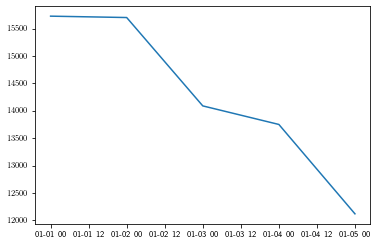

In [29]:
plt.plot(times,sinkDiat)